# Emotion Classification with the WASSA-2022 emotion dataset

In this notebook, we will use a state of the art technique from [AdityaPatkar](https://aclanthology.org/2023.wassa-1.46/) to perform emotion classification using the WASSA 2022 emotion dataset. The authors utilize a fine-tuned RoBERTa model and achieved state of the art performance through the usage of complex feature engineering and overfitting techniques. We will attempt to replicate their results using a similar approach.

## Imports

In [15]:
import transformers
import torch

import pandas as pd
import seaborn as sns

from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split

## Loading the Dataset

We observe that the dataset is a csv file, however semi-colons are used as a separator. Additionally, the labels need to be mapped to numerical values. We will load the dataset and perform these operations.

In [2]:
# Load the dataset
train = pd.read_csv('train_ready_for_WS.csv', encoding='utf-8', sep=';')
test = pd.read_csv('test.csv', encoding='utf-8', sep=';')

train.head()

,article_id,essay,emotion
0,67,it is really diheartening to read about these ...,sadness
1,86,the phone lines from the suicide prevention li...,sadness
2,206,"no matter what your heritage, you should be ab...",neutral
3,290,it is frightening to learn about all these sha...,fear
4,342,the eldest generation of russians aren't being...,sadness


In [3]:
# Obtain emotion mapping from the dataset
emotions = train['emotion'].unique()
emotion_map = {emotion: idx for idx, emotion in enumerate(emotions)}

# Convert map to dataframe
emotion_map_df = pd.DataFrame(emotion_map.items(), columns=['emotion', 'label'])
emotion_map_df

,emotion,label
0,sadness,0
1,neutral,1
2,fear,2
3,anger,3
4,disgust,4
5,surprise,5
6,joy,6


In [4]:
# Apply the mapping to the datasets
train_encoded = train.copy()
train_encoded['emotion'] = train_encoded['emotion'].map(emotion_map)

test_encoded = test.copy()
test_encoded['emotion'] = test_encoded['emotion'].map(emotion_map)

train_encoded.head()

,article_id,essay,emotion
0,67,it is really diheartening to read about these ...,0
1,86,the phone lines from the suicide prevention li...,0
2,206,"no matter what your heritage, you should be ab...",1
3,290,it is frightening to learn about all these sha...,2
4,342,the eldest generation of russians aren't being...,0


## Exploratory Data Analysis

We will perform some basic exploratory data analysis to understand the dataset better. This will include visualizing the distribution of the labels, and the distribution of the number of words in the text. To prevent data leakage, we will only examine the training set.

<Axes: xlabel='emotion', ylabel='count'>

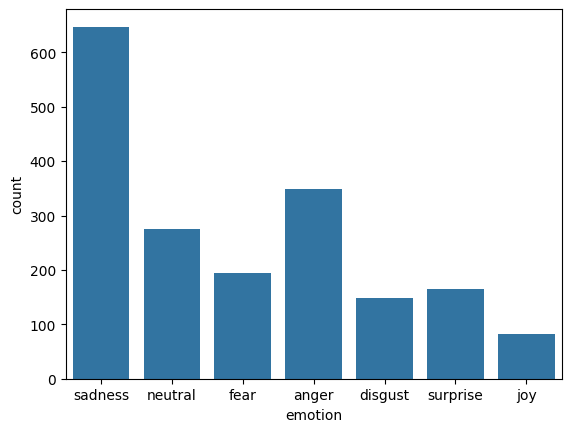

In [5]:
# Plot the distribution of the emotions, emotion is a categorical variable
sns.countplot(x=train['emotion'])

In [6]:
# Check for NA values
print(train.isna().sum())

article_id    0
essay         0
emotion       0
dtype: int64


<Axes: xlabel='Number of Words', ylabel='Count'>

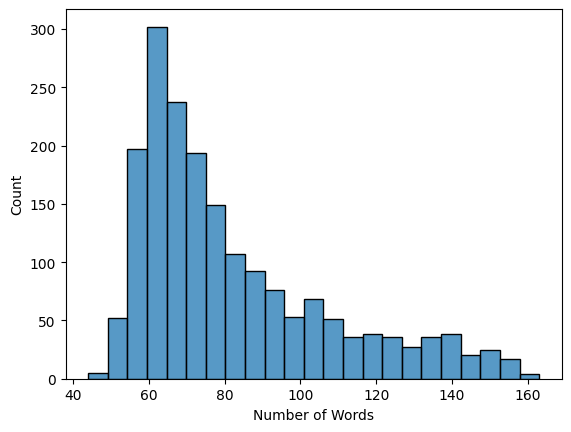

In [7]:
# Plot the distribution of number of words in an essay
train['Number of Words'] = train['essay'].apply(lambda x: len(x.split()))
sns.histplot(train['Number of Words'])

From this basic investigation, we observe that there is a severe class imbalance in the dataset. Additionally, the size of an essay varies greatly with the average hovering around 60 words. We can easily address this issue using a transformer model which can handle variable length inputs due to its attention mechanism.

## Preprocessing

We are using transformers which require minimal text pre-processing as they are designed to handle raw text. However, we will need to tokenize the text and convert it to a format that the model can understand. We will also need to address the class imbalance in the dataset using class weights. Additionally, we will split the training set into a training and validation set.

In [8]:
# Split the dataset into training and validation
train_df, val_df = train_test_split(train_encoded, test_size=0.3)

In [9]:
# Compute the class weights and add to the mapping dataframe
# We compute the class weights as w_i = N / (k * n_i)
# where N is the total number of samples, k is the number of classes and n_i is the number of samples in class i

# Compute class counts
class_counts = train['emotion'].value_counts()
class_weights = len(train) / (len(emotions) * class_counts)

# Convert to dataframe
class_weights_df = pd.DataFrame(class_weights)
class_weights_df.reset_index(inplace=True)

# Merge with emotion_map_df using emotion column
emotion_map_df = emotion_map_df.merge(class_weights_df, on="emotion")
emotion_map_df

,emotion,label,count
0,sadness,0,0.410687
1,neutral,1,0.966234
2,fear,2,1.369661
3,anger,3,0.761359
4,disgust,4,1.783317
5,surprise,5,1.620209
6,joy,6,3.240418


In [10]:
# Create pytorch dataset
class EmotionDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        essay = self.data.iloc[idx]['essay']
        label = self.data.iloc[idx]['emotion']

        encoding = self.tokenizer.encode_plus(
            essay,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'essay': essay,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long),
            'weight': torch.tensor(emotion_map_df['label'][label], dtype=torch.float)
        }

In [11]:
# Create Dataloader which is used to iterate over the dataset
def create_dataloader(data, tokenizer, max_length, batch_size):
    dataset = EmotionDataset(data, tokenizer, max_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
# Constants
BATCH_SIZE = 256

# Get the maximum length of the essay
max_length = train['Number of Words'].max()

# Obtain roberta tokenizer and create dataloader for dataset
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
train_loader = create_dataloader(train_df, tokenizer, max_length, BATCH_SIZE)
val_loader = create_dataloader(val_df, tokenizer, max_length, BATCH_SIZE)
test_loader = create_dataloader(test_encoded, tokenizer, max_length, BATCH_SIZE)

## Model Creation

Creation of classes required for the model which take hyperparameters as input.

## Model Training

Training loop with hyperparameter tuning

## Model Evaluation

Macro F1 score, Micro F1 score, precision, recall, confusion matrix